[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

# DBSCAN Demo

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 13/04/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0061ClusteringDBSCAN.ipynb)

In [5]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

# Miscellaneous
import math
import os
from platform import python_version
import random
import timeit

# Typing
from typing import Callable, Dict, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [6]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())


In [7]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2


In [8]:
# Courses Packages
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from utils.DataVisualization import PlotScatterData


In [9]:
# General Auxiliary Functions

def PlotDBSCAN( mX: np.ndarray, rVal:float, minSamples: int, metricMethod: str, hA: Optional[plt.Axes] = None, figSize: Tuple[int, int] = FIG_SIZE_DEF, markerSize: int = MARKER_SIZE_DEF ) -> plt.Axes:

    if hA is None:
        hF, hA = plt.subplots(figsize = figSize)
    else:
        hF = hA.get_figure()

    vL = DBSCAN(eps = rVal, min_samples = minSamples, metric = metricMethod).fit_predict(mX)
    numClusters = vL.max() + 1

    vIdxC = vL > -1 #<! Clusters
    vIdxN = vL == -1 #<! Noise

    vC = np.unique(vL[vIdxC])
    for ii in range(numClusters):
        vIdx = vL == ii
        hA.scatter(mX[vIdx, 0], mX[vIdx, 1], s = ELM_SIZE_DEF, edgecolor = EDGE_COLOR, label = f'{ii}')
    
    hA.scatter(mX[vIdxN, 0], mX[vIdxN, 1], s = 2 * ELM_SIZE_DEF, edgecolor = 'r', label = 'Noise')

    # hA.scatter(mX[vIdxC, 0], mX[:, 1], s = ELM_SIZE_DEF, c = vL[vIdxC], edgecolor = EDGE_COLOR)
    # hA.scatter(mX[vIdxN, 0], mX[:, 1], s = ELM_SIZE_DEF, c = vL[vIdxN], edgecolor = EDGE_COLOR)
    # hS = hA.scatter(mX[:, 0], mX[:, 1], s = ELM_SIZE_DEF, c = vL, edgecolor = EDGE_COLOR)
    hA.set_xlabel('${{x}}_{{1}}$')
    hA.set_ylabel('${{x}}_{{2}}$')
    hA.set_title(f'DBSCAN Clustering, Number of Clusters: {numClusters}, Number of Noise Labels: {np.sum(vIdxN)}')
    hA.legend()

    return hA


## Clustering by Density

This notebook demonstrates clustering using the [_DBSCAN_](https://en.wikipedia.org/wiki/DBSCAN) algorithm.  

* <font color='brown'>(**#**)</font> The _DBSCAN_ method approximates the idea of applying the high dimensionality KDE, applying a threshold and finding the connected components.
* <font color='brown'>(**#**)</font> The _DBSCAN_ method was improved by other methods. Notable mentions: [OPTICS Algorithm](https://en.wikipedia.org/wiki/OPTICS_algorithm) and [HDBSCAN](https://github.com/scikit-learn-contrib/hdbscan).  
  The improvements mostly try to better handle varying density among the clusters.

In [10]:
# Parameters

# Data Generation
vNumSamples = [250, 250, 50] #<! Moon 001, Moon 002, Noise

# Model

## Generate / Load Data

The data is composed on several _moon_ like shaped clusters and noise.

In [11]:
# Generate Data

mX0, _ = make_moons(vNumSamples[0], noise = .05)
mX1, _ = make_moons(vNumSamples[1], noise = .05)
mX1    = mX1 * [1, -1] + [0, 3]
mX2    = np.random.rand(vNumSamples[2], 2) * [4, 5] - [1.75, 2/3]
mX     = np.r_[mX0, mX1, mX2]
vL     = np.repeat(range(len(vNumSamples)), vNumSamples)

print(f'The features data shape: {mX.shape}')

The features data shape: (550, 2)


### Plot Data

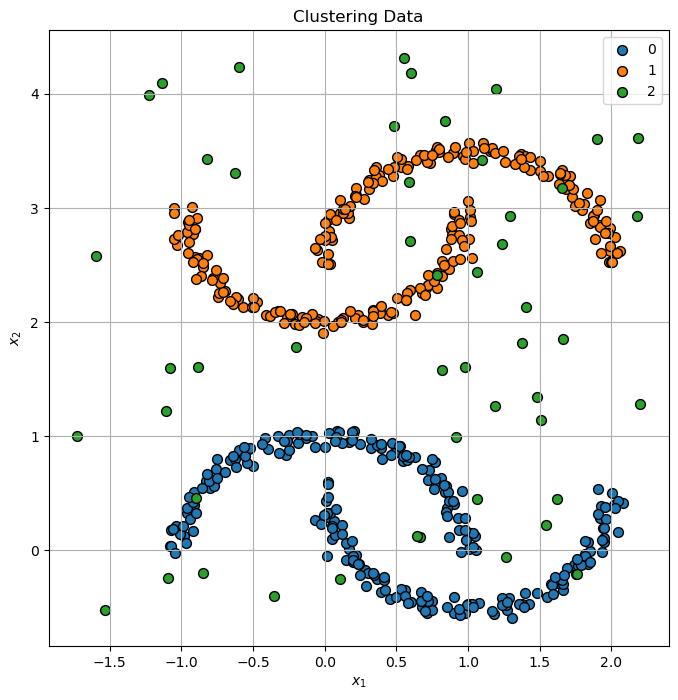

In [12]:
# Plot the Data

hF, hA = plt.subplots(figsize = (8, 8))
hA = PlotScatterData(mX, vL, hA = hA)
hA.set_title('Clustering Data');

## Cluster Data by DBSCAN

The DBSCAN method is one of the mor intuitive method (Though tricky to implement efficiently).  
It is super powerful and effective, yet requires tweaking of its hyper parameters.  

* <font color='brown'>(**#**)</font> One advantage of the method is the built in support for outliers. Yet, it is not a perfect method (Since _noise is not always an outlier_!).
* <font color='brown'>(**#**)</font> As a non parametric method, it doesn't have built in support for new samples (Out of sample data).
* <font color='brown'>(**#**)</font> Support for new samples might be done using s supervised model.
* <font color='brown'>(**#**)</font> It might be tricky with large data sets and high dimensionality.
* <font color='brown'>(**#**)</font> Implemented in SciKit Learn's [`DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) class.  
* <font color='brown'>(**#**)</font> SciKit Learn offers 2 improvements: [`HDBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html), [`OPTICS`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html).  

In [13]:
# Plotting Function Wrapper
hPlotDbscan = lambda rVal, minSamples, metricMethod: PlotDBSCAN(mX, rVal, minSamples, metricMethod, figSize = (7, 7))

In [14]:
# Interactive Visualization

# There are two parameters to the algorithm, `min_samples` and `eps`, which define formally what we mean when we say dense.
# Higher `min_samples` or lower `eps` indicate higher density necessary to form a cluster.

rSlider = FloatSlider(min = 0.05, max = .5, step = 0.05, value = 0.05, layout = Layout(width = '30%'))
zSlider = IntSlider(min = 1, max = 10, step = 1, value = 3, layout = Layout(width = '30%'))
metricMethodDropdown = Dropdown(description = 'Metric Method', options = [('Cityblock', 'cityblock'), ('Cosine', 'cosine'), ('Euclidean', 'euclidean')], value = 'euclidean')
interact(hPlotDbscan, rVal = rSlider, minSamples = zSlider, metricMethod = metricMethodDropdown)

plt.show()

interactive(children=(FloatSlider(value=0.05, description='rVal', layout=Layout(width='30%'), max=0.5, min=0.0…